**Google’s Open Images Dataset** link https://storage.googleapis.com/openimages/web/download.html
Απο αυτον τον συνδεσμο κατεβαζουμε τα Class Names(βημα 1) και επειτα παταμε Download from Figure Eight(βημα 2)

<img src="Input/OpenImagesDatasetV6.png">

Αφου εκτελεσουμε το (βημα 2) κατεβαζουμε τα δυο παρακατω αρχεια:
<img src="Input/trainAnnotations.png">

Οταν κατεβουν τα 3 αρχεια τα σωζουμε στο τρεχον path και συνεχιζουμε με τον παρακατω κωδικα.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
tf.__version__


'2.1.0'

# Load data from .csv file

* `train-images-boxable.csv` το αρχειο αυτο περιεχει το ονομα της εικονας και το url που μπορουμε να την κατεβασουμε.
* `train-annotations-bbox.csv` το αρχειο περιεχει τις συντεταγμενες οπου βρισκεται το καθε αντεικειμενο στην εικονα καθως και το id της κατηγοριας αυτης.
* `class-descriptions-boxable.csv` το αρχειο περιεχει τα id's των κατηγωριων καθως και τα ονοματα τους

In [4]:
images_boxable_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\train-images-boxable.csv"
annotations_bbox_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\train-annotations-bbox.csv"
class_descriptions_fname = r"C:\Users\Christos\Jupyter\Vision\Ask4part3\Final\Code\Inputs\class-descriptions-boxable.csv"

In [5]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.tail()

image_name  \
1743037  0600da870728676a.jpg   
1743038  0bffbae4aa7654b6.jpg   
1743039  0cbe670c7e0cebfc.jpg   
1743040  0aa947b5ee5940ee.jpg   
1743041  02a20d625073c07a.jpg   

                                                 image_url  
1743037  https://requestor-proxy.figure-eight.com/figur...  
1743038  https://requestor-proxy.figure-eight.com/figur...  
1743039  https://requestor-proxy.figure-eight.com/figur...  
1743040  https://requestor-proxy.figure-eight.com/figur...  
1743041  https://requestor-proxy.figure-eight.com/figur...

In [6]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.148438  0.587500           0            1  ...            0         0   
1  0.714063  0.948438           0            1  ...            0         0   
2  0.198437  0.590625           1            0  ...            0         0   
3  0.651563  0.925000           1            0  ...            0         0   
4  0.235938  0.385938           1            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.148438  0.012500  0.059375  0.195312  0.148438  0.357812  0.587500   
1  0.025000  0.248438  0.276563  0.214062  0.914062  0.714063  0.782813   
2  0.243750  0.151562  0.310937  0.262500  0.198437  0.434375  0.507812   
3  0.315625  0.429688  0.256250  0.423438  0.651563  0.921875  0.826562   
4  0.317188  0.257812  0.346875  0.307812  0.235938  0.289062  0.348438   

   XClick4Y  
0  0.325000  
1  0.948438  
2  0.590625  
3  0.925000  
4  0.385938  

[5 rows x 21 columns]

In [7]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

get image url with the image name

In [8]:
img_id = "e39871fd9fd74f55"
img_url = images_boxable.loc[images_boxable["image_name"]==img_id + ".jpg"]['image_url'].values[0]
img_url

'https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e39871fd9fd74f55.jpg'

Με την παρακατω ρουτινα θα εμφανιζουμε μια εικονα μαζι με τα bounding box δινοντας το ονομα της εικόνας.

In [9]:
def plot_bbox(img_id):
  img_name = img_id + ".jpg"
  img_url = images_boxable.loc[images_boxable["image_name"]==img_name]['image_url'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Παμε λοιπον να εμφανισουμε μερικες εικονες


Επιλεγουμε εικονες οι οποιες δεν εχουν πολλα αντεικειμενα ωστε να μπορεσουμε να τα διακρινουμε.

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (768, 1024, 3)
Coordinates: (0, 0), (855, 305)


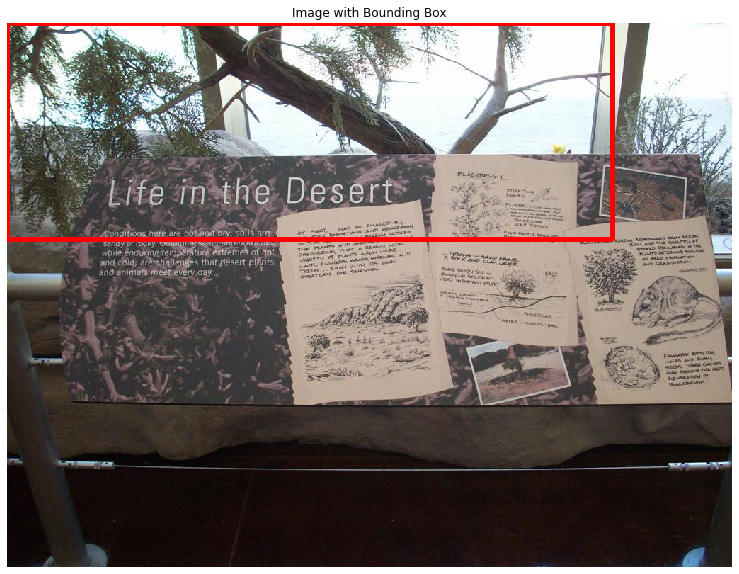

Image: (768, 1024, 3)
Coordinates: (348, 252), (888, 540)


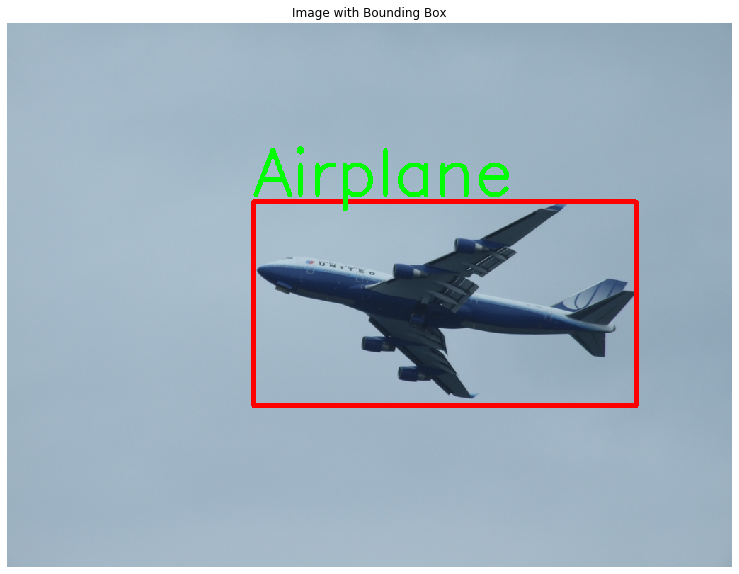

Image: (1024, 768, 3)
Coordinates: (0, 118), (767, 1023)


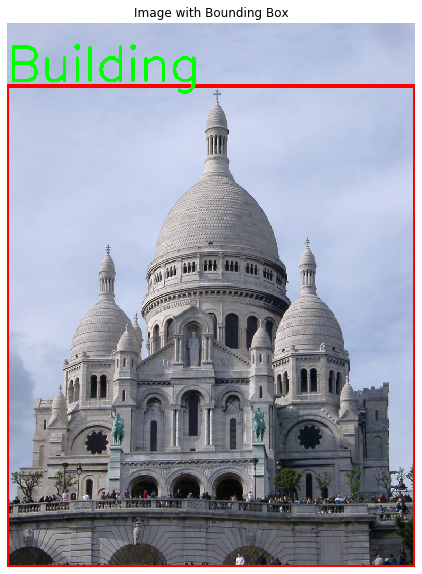

Image: (697, 1024, 3)
Coordinates: (537, 275), (928, 627)


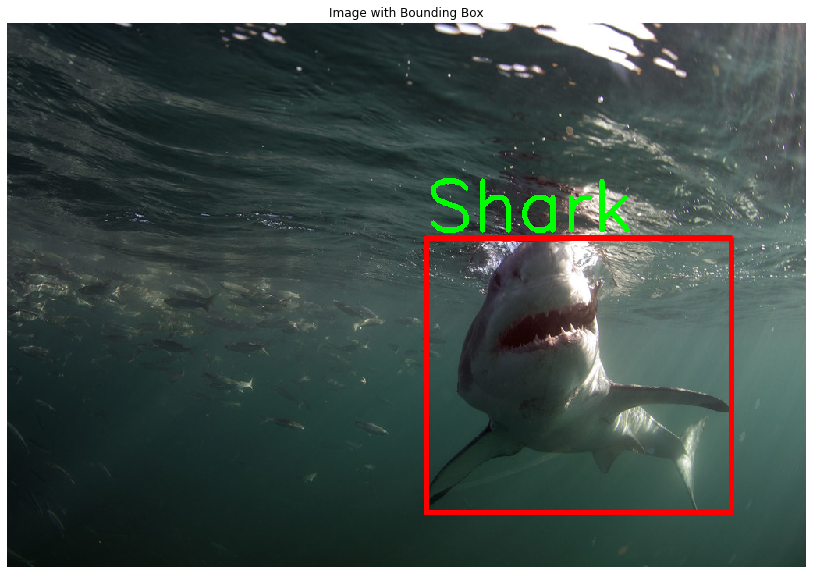

Image: (1024, 1024, 3)
Coordinates: (97, 150), (890, 818)


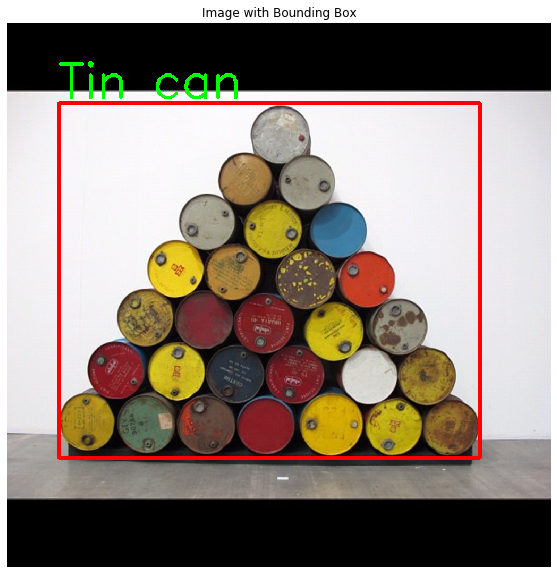

In [11]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

Επιλεγουμε 1000 εικονες απο τις 3 κατηγοριες 'Person', 'Dog', 'Cat'.

In [10]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Dog', 'Cat'])]

0       1
68   /m/01g317  Person
121   /m/01yrx     Cat
445  /m/0bt9lr     Dog

In [11]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
class1_pd = class_descriptions[class_descriptions[1]=='Person']
class2_pd = class_descriptions[class_descriptions[1]=='Dog']
class3_pd = class_descriptions[class_descriptions[1]=='Cat']

label_name_class1 = class1_pd[0].values[0]
label_name_class2 = class2_pd[0].values[0]
label_name_class3 = class3_pd[0].values[0]

In [12]:
class1_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class1]
class2_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class2]
class3_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_class3]

In [13]:
print('There are %d persons in the dataset' %(len(class1_bbox)))
print('There are %d phones in the dataset' %(len(class2_bbox)))
print('There are %d cars in the dataset' %(len(class3_bbox)))
class1_img_id = class1_bbox['ImageID']
class2_img_id = class2_bbox['ImageID']
class3_img_id = class3_bbox['ImageID']

There are 1034721 persons in the dataset
There are 28675 phones in the dataset
There are 15183 cars in the dataset


In [14]:
class1_img_id = np.unique(class1_img_id)
class2_img_id = np.unique(class2_img_id)
class3_img_id = np.unique(class3_img_id)
print('There are %d images which contain persons' % (len(class1_img_id)))
print('There are %d images which contain phones' % (len(class2_img_id)))
print('There are %d images which contain cars' % (len(class3_img_id)))

There are 248384 images which contain persons
There are 20607 images which contain phones
There are 12516 images which contain cars


randomly pick 1000 images .

In [17]:

n = 1000
subclass1_img_id = random.sample(list(class1_img_id), n)
subclass2_img_id = random.sample(list(class2_img_id), n)
subclass3_img_id = random.sample(list(class3_img_id), n)

In [18]:
subclass1_img_id.__len__()

1000

In [19]:
subclass1_img_name = [id + ".jpg" for id in subclass1_img_id]
subclass2_img_name = [id + ".jpg" for id in subclass2_img_id]
subclass3_img_name = [id + ".jpg" for id in subclass3_img_id]

In [20]:
subclass1_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass1_img_name)]
subclass2_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass2_img_name)]
subclass3_pd = images_boxable.loc[images_boxable['image_name'].isin(subclass3_img_name)]

In [21]:
subclass2_pd.shape

(1000, 2)

In [22]:
subclass1_pd.head()

image_name                                          image_url
147   ec8d58e5a10be4a6.jpg  https://requestor-proxy.figure-eight.com/figur...
1270  ff8e66c987237872.jpg  https://requestor-proxy.figure-eight.com/figur...
2051  f85f1644f13f9084.jpg  https://requestor-proxy.figure-eight.com/figur...
3716  f0c8b063f7ccbe9e.jpg  https://requestor-proxy.figure-eight.com/figur...
4134  fa4796938b28b0ea.jpg  https://requestor-proxy.figure-eight.com/figur...

In [23]:
subclass1_dict = subclass1_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()
subclass2_dict = subclass2_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()
subclass3_dict = subclass3_pd[["image_name", "image_url"]].set_index('image_name')["image_url"].to_dict()


In [24]:
subclass2_dict.__len__()

1000

In [25]:
mappings = [subclass1_dict, subclass2_dict, subclass3_dict]

In [26]:
len(mappings)

3

In [27]:
len(mappings[0])

1000

In [28]:
classes = ['Person', 'Dog', 'Cat']

# Download images

Αφου εχουμε δημιουτγησει ενα subset απο την συνολικη βαση. Ηρθε η στιγμη να κατεβασουμε τις 3000 εικονες. 

In [29]:
os.getcwd()
os.chdir(r"C:\Users\Christos\Google Drive\ColabNotebooks\Vision\frcnn\keras-frcnn")

ρουτινα η οποια κατεβαζει τις εικονες και τις αποθηκευει ανα κατηγορια

In [73]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_name, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_name)
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 0
Images Issues: 0
Images Issues: 0


### Dataset format for Faster-RCNN 

Το μοντελο μας το μονο που χρειαζεται για να γινει η εκπαιδευση ειναι ενα αρχειο txt της παρακατω μορφης:
(fname_path, xmin, xmax, ymin, ymax, class_name)
πρωτα γραφουμε το path στο οποιο βρισκεται η εικονα μετα τις συντεταγμενες στις οποιες βρισκεται το αντικειμενο μεσα στην εικονα (χωρισεμενες με ',') και τελος την κατηγορια του αντικειμενου.

train: 0.8
validation: 0.2

In [30]:
classes = ['Person', 'Dog', 'Cat']
# here I've chosen only 10 images for speed, change it to your liking
n = 1000

In [31]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [76]:
random.seed(1)

In [79]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [33]:
label_names = [label_name_class1, label_name_class2, label_name_class3]

In [81]:


train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [82]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  00039bbe6dbd4fc5.jpg  0.012500  0.453125  0.052500  0.930000    Person
1  0008994c6ecc4226.jpg  0.382500  0.999375  0.298333  0.743333    Person
2  000bd897ca7df023.jpg  0.411875  0.906250  0.000000  0.996248    Person
3  000bd897ca7df023.jpg  0.168125  0.435000  0.223265  0.815197       Cat
4  0013957a5d6e987d.jpg  0.261250  0.280000  0.308333  0.368333    Person

In [83]:
train_df.shape

(5938, 6)

In [84]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (768, 1024, 3)
Coordinates: (12, 40), (464, 714)
Coordinates: (0, 262), (72, 451)
Coordinates: (19, 110), (469, 714)
Coordinates: (26, 0), (1023, 593)
Coordinates: (329, 2), (405, 214)


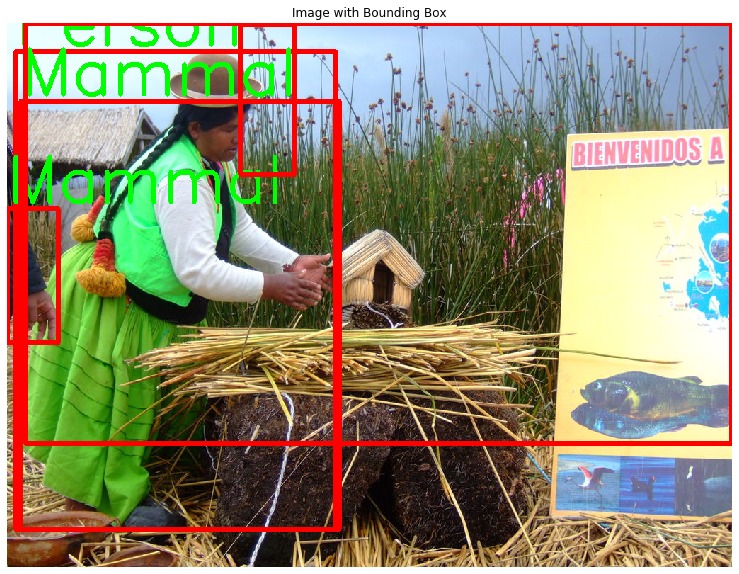

Image: (768, 1024, 3)
Coordinates: (391, 229), (1023, 570)
Coordinates: (506, 279), (739, 538)
Coordinates: (789, 62), (972, 167)


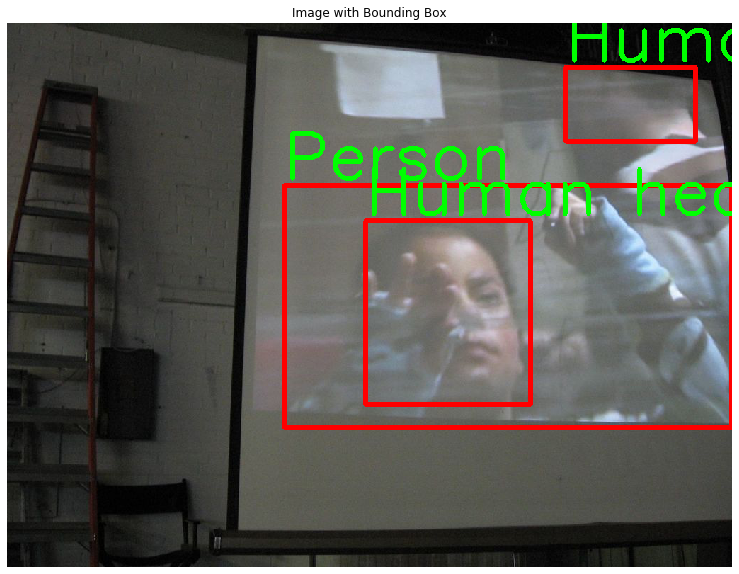

Image: (683, 1024, 3)
Coordinates: (421, 0), (928, 680)
Coordinates: (172, 152), (445, 556)
Coordinates: (508, 0), (706, 236)


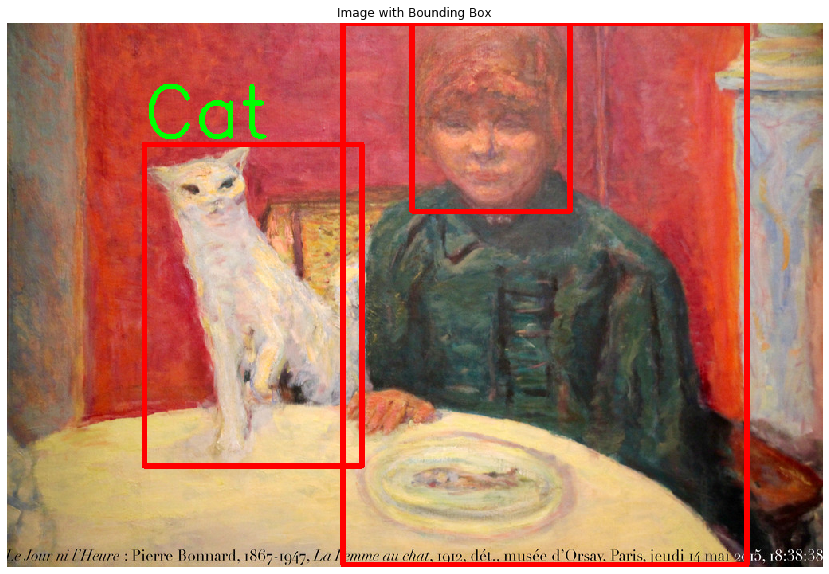

Image: (768, 1024, 3)
Coordinates: (267, 236), (286, 282)
Coordinates: (47, 218), (308, 401)
Coordinates: (481, 286), (971, 606)
Coordinates: (0, 0), (750, 363)
Coordinates: (782, 0), (1022, 407)


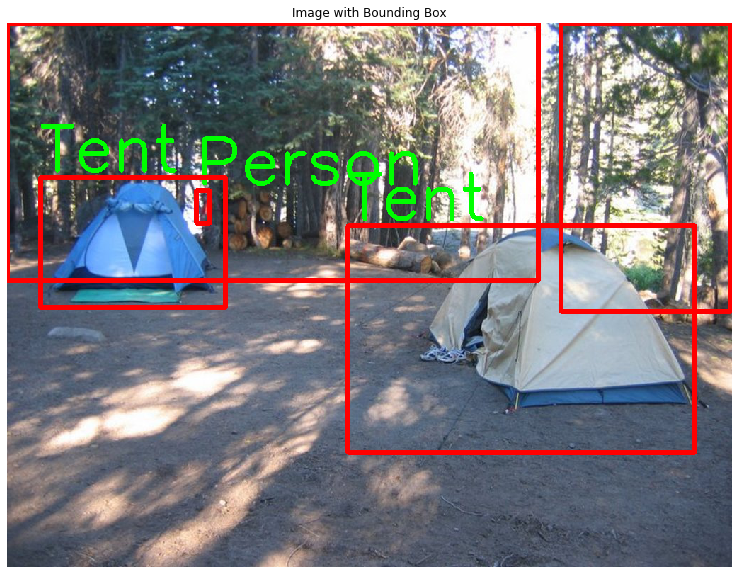

In [85]:
for img_id in train_img_ids:
  plot_bbox(img_id)

test.csv

In [43]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    
    img = cv2.imread('test/' + img_name)
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    
    with open("groundtruths/{}.txt".format(img_id), "w+") as f:
         for index, row in tmp_df.iterrows():
                
                labelName = row['LabelName']
                
                for i in range(len(label_names)):
                    if labelName == label_names[i]:
                        test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)
                        f.write(classes[i] + ' ' + str(x1) + ' ' + str(y1) + ' ' + str(x2) + ' ' + str(y2) + '\n')
         f.close()


Σε αυτο το σημειο πρεπει να φτιαξουμε το txt αρχειο για το evaluetion

In [37]:
test_df.tail()

FileName      XMin      XMax      YMin      YMax ClassName
1364  fe08ce283ed9fe00.jpg  0.827500  0.911875  0.510934  0.592445       Cat
1365  fe952e7df9c5d743.jpg  0.458333  0.622500  0.315000  0.458125       Cat
1366  fec284c3a0d5a346.jpg  0.186667  0.392500  0.202500  0.389375    Person
1367  ff1196d7cac681dc.jpg  0.176471  0.915033  0.236928  0.633987       Dog
1368  ffb943a17cbbdcda.jpg  0.000000  0.990196  0.150327  0.838235       Cat

In [ ]:
train_df.to_csv('train.csv')

In [89]:
test_df.to_csv('test.csv')

In [93]:
train_df = pd.read_csv('train.csv')
#/content/gdrive/My Drive/ColabNotebooks/Vision/frcnn/keras-frcnn
# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = '/content/gdrive/My Drive/ColabNotebooks/Vision/frcnn/keras-frcnn/train'
      fileName = google_colab_file_path + "/" + row['FileName']
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
results_df = pd.read_csv('test.csv')